## Determining star temperature

We received a task from the observatory: to figure out how to use a neural network to determine the temperature on the surface of detected stars. 

Usually , scientists use the following methods to calculate the temperature:

- The law of displacement of Wine
- Stefan-Boltzmann Law
- Spectral analysis

Each of them has pros and cons. 

The observatory wants to introduce machine learning technologies to predict the temperature of stars, hoping that this method will be the most accurate and convenient.

The observatory's database contains the characteristics of 240 stars that have already been studied.

**Features**

- Relative luminosity **`L/Lo`** — luminosity of a star relative to the Sun
- Relative radius **`R/Ro`** — radius of the star relative to the radius of the Sun
- Absolute magnitude **`Mv`** — a physical quantity that characterizes the brilliance of a star
- Star color (**`white`**, **`red`**, **`blue`**, **`yellow`**, **`yellow-orange`**, etc.) — the color of the star, which is determined on the basis of pectral analysis
- Type of star

| Type of star | The number corresponding to the type |
| ------|------ |
| Brown dwarf | 0 |
| Red Dwarf | 1 |
| White dwarf | 2 |
| Main sequence stars | 3 |
| Supergiant | 4 |
| Hypergiant | 5 |

- Absolute temperature **`T(K)`** — temperature on the surface of the star in Kelvins.

**Background information:**

- $ L_{0} = 3.828 * 10^{26} $ W - The Luminosity of the Sun (Average Luminosity of the Sun) 
- $ R_{0} = 6.9551 * 10^{8} $ m is the Radius of the Sun (Average Radius of the Sun) 

**Project objective**

It is necessary to develop a neural network that will help predict the absolute temperature on the surface of the star.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn

## Loading data

In [2]:
df = pd.read_csv('/datasets/6_class.csv',index_col = 0)
df = df.drop(df.iloc[:, [0]], axis=1)

df.head(3)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red
2,2600,0.0003,0.1020,18.70,0,Red


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


**Conclusion:**

- imported the libraries necessary for the work
- downloaded and viewed basic information about our data

## Data preprocessing and analysis

### Exploratory data analysis

At the very beginning, rename the column names, it is very inconvenient to work with names containing spaces and different case.

In [5]:
df.columns = ['temp', 'lum_rel', 'rad_rel', 'magn', 'type', 'color']

The number of null values (was previously in *`info`*)

In [6]:
df.isnull().sum().sum()

0

Number of obvious duplicates

In [7]:
df.duplicated().sum()

0

Now let's consider the quantitative and categorical variables separately.

There are **6 signs** in our data.

**Categorical**:
 - **`type`** - type of star
 - **`color`** - star color

**Quantitative:**
 - **`temp`** - absolute temperature
 - **`lum_rel`** - relative luminosity
 - **`rad_rel`** - relative radius
 - **`magn`** - absolute magnitude
 
***Note***

For reference, we are given the values of the radius and luminosity of the Earth, but I suggest not to recalculate the relative indicators into absolute ones (**`lum_rel`**, **`rad_rel`**)

This will add extra digits to us, but it will not add informativeness.

In [8]:
cat = ['type', 'color']
num = ['temp','lum_rel','rad_rel','magn']

Next, let's look at the distributions for each of the variables.

First let 's look at the categorical:

In [9]:
for i in cat:
    print(df[i].unique())

[0 1 2 3 4 5]
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


The values of the **`color`** attribute require manual adjustment

In [10]:
df['color'] = np.where(df['color'].isin(['Blue ','Blue']),'Blue', df['color'])
df['color'] = np.where(df['color'].isin(['Blue white','Blue-white','Blue White',
                                        'Blue white ','Blue-White']),'Blue White', df['color'])
df['color'] = np.where(df['color'].isin(['White','white','Whitish']),'White', df['color'])
df['color'] = np.where(df['color'].isin(['White-Yellow','Yellowish White','yellow-white']),
                                                                    'Yellow White', df['color'])

df['color'] = np.where(df['color'].isin(['yellowish','Yellowish']),'Yellow', df['color'])

df['color'] = np.where(df['color'].isin(['Orange-Red']),'Orange Red', df['color'])

There are **`Pale yellow orange`** and **`Orange Red`** to recode them, let's look at the average temperature values

In [11]:
df.groupby('color').agg(Mean=('temp', np.mean),
                        Std= ('temp', np.std),
                        cnt= ('temp', 'count'))

,Mean,Std,cnt
color,,,
Blue,21918.339286,9453.979609,56
Blue White,16659.951220,6560.050964,41
Orange,4018.000000,380.423448,2
Orange Red,5112.000000,NaN,1
Pale yellow orange,7230.000000,NaN,1
Red,3291.785714,490.780761,112
White,9579.583333,2368.265513,12
Yellow,4527.666667,451.502307,3
Yellow White,7609.166667,2428.134444,12


In [12]:
df['color'] = np.where(df['color'].isin(['Orange Red']),'Orange', df['color'])

df['color'] = np.where(df['color'].isin(['Pale yellow orange']),'Yellow White', df['color'])

Check

In [13]:
for i in cat:
    print(df[i].unique())

[0 1 2 3 4 5]
['Red' 'Blue White' 'White' 'Yellow White' 'Blue' 'Orange' 'Yellow']


In [14]:
df.groupby('color').agg(Mean=('temp', np.mean),
                        Std= ('temp', np.std),
                        cnt= ('temp', 'count'))

,Mean,Std,cnt
color,,,
Blue,21918.339286,9453.979609,56
Blue White,16659.951220,6560.050964,41
Orange,4382.666667,686.517540,3
Red,3291.785714,490.780761,112
White,9579.583333,2368.265513,12
Yellow,4527.666667,451.502307,3
Yellow White,7580.000000,2327.139052,13


CPU times: user 72.8 ms, sys: 3.74 ms, total: 76.5 ms
Wall time: 77.3 ms


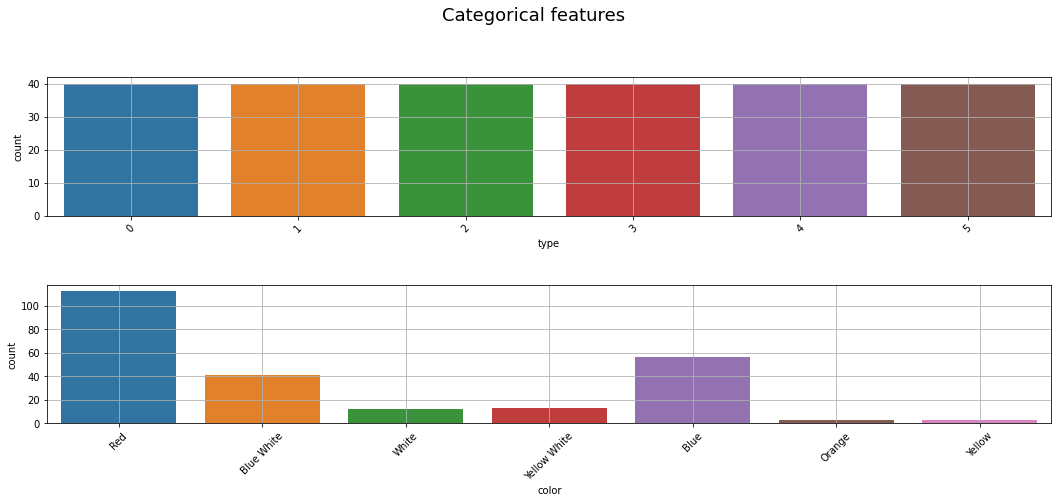

In [15]:
%%time

plt.figure(figsize = (18, 14))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle("Categorical features", fontsize = 18, y = 0.95)

for n, ct in enumerate(cat):
    ax = plt.subplot(4, 1, n + 1)
    sns.countplot(x = df[ct], ax = ax)
    plt.xticks(rotation=45)
    plt.grid(True)

Now the quantitative variables

We will select the temperature separately - then it will be the target variable

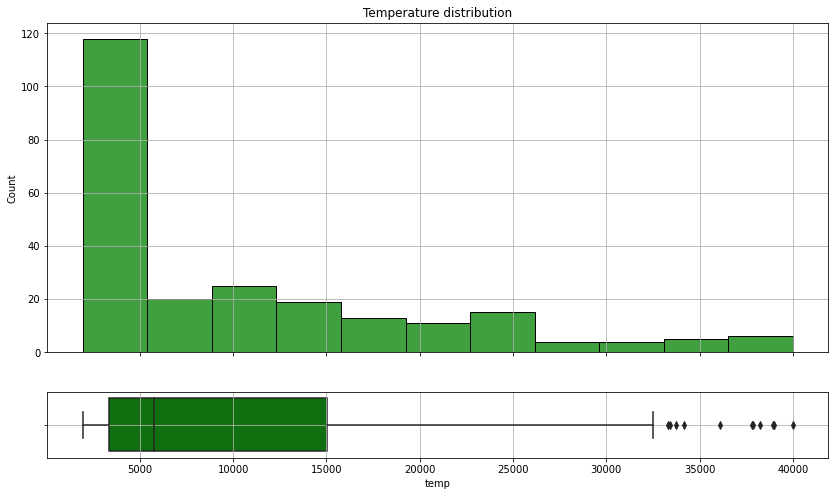

In [16]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex = True, gridspec_kw = {"height_ratios": (5, 1)}, figsize = (14,8))
sns.histplot(data = df, x = "temp", ax = ax_hist, color = 'green',  fill = True)
ax_hist.set_title("Temperature distribution")
ax_hist.grid()

sns.boxplot(data = df, x = "temp", ax = ax_box, color = 'green')
ax_box.grid()
plt.show()

CPU times: user 62.1 ms, sys: 2.7 ms, total: 64.8 ms
Wall time: 63.8 ms


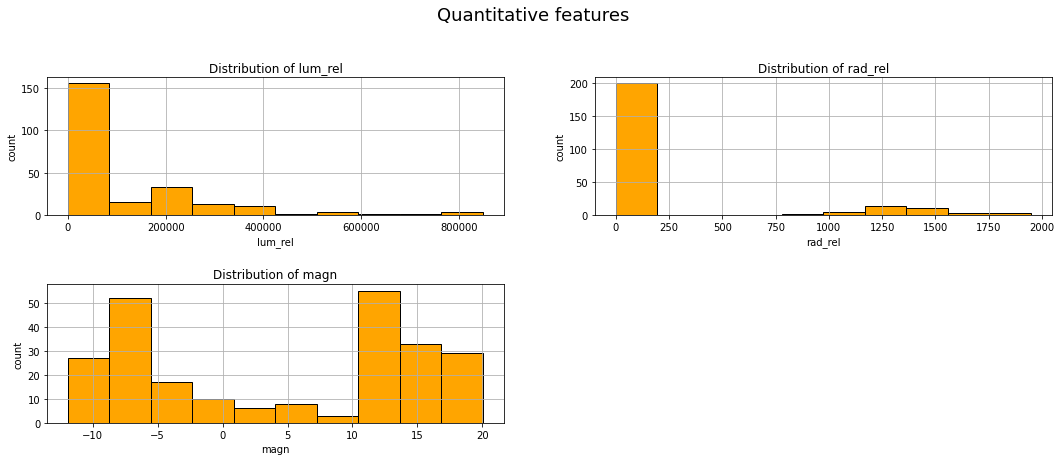

In [17]:
%%time

num_grph = ['lum_rel','rad_rel','magn']

plt.figure(figsize = (18, 14))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle("Quantitative features", fontsize = 18, y = 0.95)

for n, ct in enumerate(num_grph):
    ax = plt.subplot(4, 2, n + 1)
    ax = plt.hist(df[ct], color = 'orange', edgecolor= 'black')
    plt.title(f'Distribution of {ct}')
    plt.xlabel(ct)
    plt.ylabel('count')
    plt.grid(True)

Now let's look at the dependencies between the variables in our dataset

**Let's build a scatter diagram**

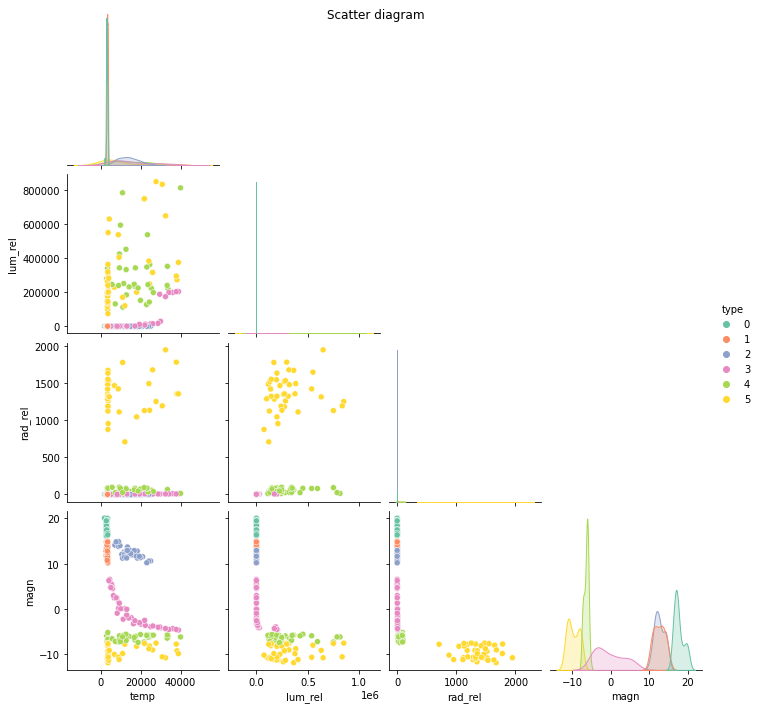

In [18]:
sns.pairplot(df, hue = 'type' ,corner = True, palette = 'Set2')
plt.suptitle("Scatter diagram")
plt.show()

**Let's build a correlation matrix**

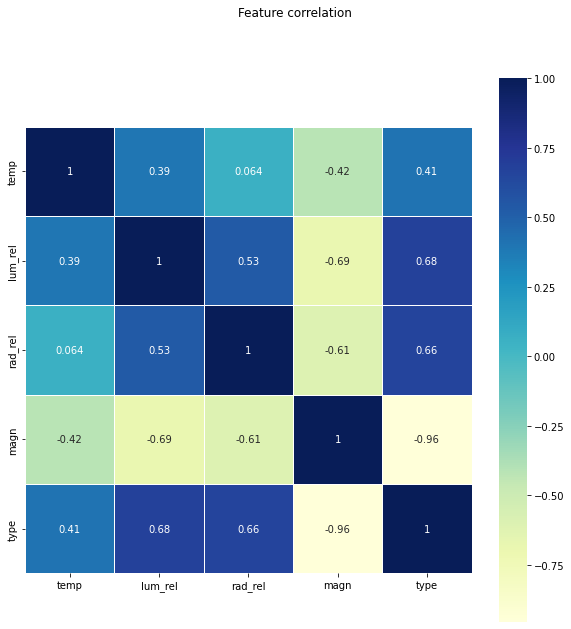

In [19]:
fig, ax = plt.subplots(figsize = (10,10))    

sns.heatmap(df.corr(), annot = True, linewidths=.5, cmap="YlGnBu", square=True, ax = ax)
plt.suptitle("Feature correlation")
plt.show()

**Conclusion**

- the amount of data for the research is very small:
    - 250 records
    - 2 categorical and 4 quantitative variables
- there are no omissions and obvious duplicates in the data
- the values of the **`color`** attribute have been adjusted manually
- when considering the parameters in detail, it was not possible to identify obvious regularities
    - both the distribution of each variable in buckets separately
    - and pairwise dependencies (scatter diagram and correlation matrix) were considered
- the only significant observation is the strong dependence of the type of star `type` and the absolute magnitude `magn`

### Preparing data for model training

We will scale quantitative data and OHE categorization of categorical variables

In [20]:
scaler = StandardScaler()
ohe = OneHotEncoder() 

In [21]:
for col in num:
    df[str(col) + "_sc"] = scaler.fit_transform(df[[col]])

tp = ohe.fit_transform(df['type'].values.reshape(-1,1)).toarray()
clr = ohe.fit_transform(df['color'].values.reshape(-1,1)).toarray()

dfOneHot = pd.DataFrame(tp, columns = ["tp"+str(int(i)) for i in range(tp.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)

dfOneHot = pd.DataFrame(clr, columns = ["clr_"+str(int(i)) for i in range(clr.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)

df['temp'] = df['temp'].astype('float')

In [22]:
df.columns

Index(['temp', 'lum_rel', 'rad_rel', 'magn', 'type', 'color', 'temp_sc',
       'lum_rel_sc', 'rad_rel_sc', 'magn_sc', 'tp0', 'tp1', 'tp2', 'tp3',
       'tp4', 'tp5', 'clr_0', 'clr_1', 'clr_2', 'clr_3', 'clr_4', 'clr_5',
       'clr_6'],
      dtype='object')

We will prepare train and test samples

In [23]:
df_mdl = df.drop(columns = cat + num).copy()

X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    df_mdl.drop(columns = ['temp_sc']), 
    df_mdl.temp_sc, 
    test_size = 0.3, 
    shuffle = True,
    random_state = 12345)

X_train = torch.FloatTensor(X_train_pd.values)
X_test = torch.FloatTensor(X_test_pd.values)
y_train = torch.FloatTensor(y_train_pd.values)
y_test = torch.FloatTensor(y_test_pd.values)

In [24]:
X_train.shape

torch.Size([168, 16])

**Conclusion**
- prepared data for neural network training:
    - performed scaling for numeric features
    - performed OHE coding for categorical variables
- split the data into train and test parts

## Basic neural network training

**Main task:** Prediction of the temperature of the star

**Target variable:** temp_sc

**What type of task is being solved:** A quantitative feature is predicted - we solve the regression problem

**Quality metric:** RMSE

**Customer requirements:** *`RMSE < 4500`*

In [25]:
INPUT_SIZE = 16
HIDDEN_SIZE = 32
HIDDEN_SIZE_2 = 10
NUM_CLASSES = 1

NUM_EPOCHS = 2000
LEARNING_RATE = 0.001

Let's create a class for setting a neural network:

In [26]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size,hidden_size_2,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size_2) 
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, num_classes) 
        
     
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        out = self.fc3(out)
        return out

In [27]:
model = NeuralNet(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_SIZE_2, NUM_CLASSES)

Output the network configuration for verification:

In [28]:
model

NeuralNet(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
standard_temp = StandardScaler().fit(df[['temp']])

Next, we will write a function for training the model, we will input the number of epochs and the step of calculating the metric, as well as the model itself

In [30]:
def fit_nn(md, n_epoch, step_epoch):
    
    t1 = datetime.datetime.now()
    
    loss = nn.MSELoss() 

    optimizer = torch.optim.Adam(md.parameters(), lr = LEARNING_RATE) 
    
    rmse_prev = 0
    
    for epoch in range(n_epoch):

        optimizer.zero_grad()

        preds = md.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % step_epoch == 0 or epoch == n_epoch - 1:
            
            md.eval()

            preds_test = md.forward(X_test)

            y_scale_inx_test = pd.DataFrame(y_test_pd)
            y_scale_inx_test['temp_pred'] = standard_temp.inverse_transform(preds_test.detach().numpy())
            y_scale_inx_test = y_scale_inx_test.join(df[['temp']], how = 'inner' )
            y_scale_inx_test = y_scale_inx_test.reset_index()
            rmse = math.sqrt(mean_squared_error(y_scale_inx_test[['temp_pred']], y_scale_inx_test[['temp']]))
            
            if rmse < rmse_prev or rmse_prev == 0: 
            
                rmse_prev = rmse
                 
            else:
                break
         
    
    t2 = datetime.datetime.now()
    
    time_lr = round((t2-t1).total_seconds(), 1)

    data = {
           'epoch': [str(epoch + 1) + '/' + str(n_epoch)],
           'loss_value': [np.round(loss_value.data.numpy(), 2)],
           'RMSE': [round(rmse,2)],
           'time_calc': [time_lr]
           }
 
    res_dt = pd.DataFrame(data)
    
    print ('epoch [{}/{}], loss_value: {:.4f} RMSE: {}, time_calc: {}' 
                           .format(epoch + 1, n_epoch, loss_value, rmse, time_lr))
            
    return y_scale_inx_test, res_dt

We conduct model training:

In [31]:
model = NeuralNet(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_SIZE_2, NUM_CLASSES)
result, dt_end = fit_nn(model, 2000, 200)

epoch [1601/2000], loss_value: 0.0768 RMSE: 4257.517194290087, time_calc: 1.4


In [32]:
dt_end

,epoch,loss_value,RMSE,time_calc
0,1601/2000,0.08,4257.52,1.4


We will show the predicted temperature for each object from the test sample:

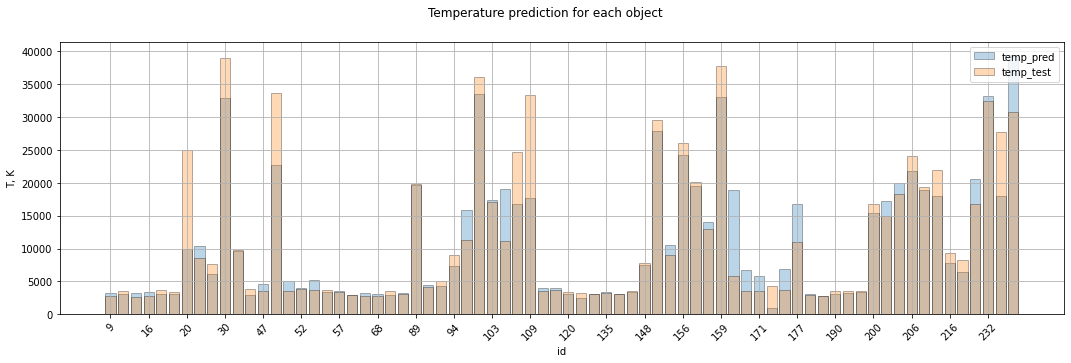

In [33]:
fig, ax = plt.subplots(figsize = (18, 5))

result = result.sort_values(by = 'index')

ax.bar(result['index'].astype('str'),  result['temp_pred'], edgecolor='black', alpha=0.3, label = 'temp_pred')
ax.bar(result['index'].astype('str'),  result['temp'], edgecolor='black', alpha=0.3, label = 'temp_test')
ax.set_xticks(list(result['index'].astype('str')[::3]))

plt.grid(True)
plt.xticks(rotation=45)
plt.legend(loc = "upper right")
plt.suptitle("Temperature prediction for each object")
plt.xlabel('id')
plt.ylabel('T, K')
plt.show()

**Conclusion:**
- created a class for setting a neural network with the selected architecture
- we wrote a function for training the model with the setting of the number of iterations and the training step
- built a graph with visualization of prediction and fact for each object from the test sample

## Neural network tuning

Next, we need to organize a search of neural network parameters to choose the best model.

Optimization paths:
- batch_size
- dropout

**Batch_size**

In [34]:
class NeuralNet_batch(nn.Module):
   
    def __init__(self, input_size, hidden_size,hidden_size_2,num_classes):
        super(NeuralNet_batch, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size_2) 
        self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, num_classes) 
        
     
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.act2(out)
        out = self.fc3(out)
        
        return out

In [35]:
model_batch = NeuralNet_batch(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_SIZE_2, NUM_CLASSES)

In [36]:
n_epoch = 600 
step_epoch = 200
batch_size = 50

t1 = datetime.datetime.now()

loss = nn.MSELoss() 

optimizer = torch.optim.Adam(model_batch.parameters(), lr = LEARNING_RATE) 

flag = False
rmse_prev = 0

num_batches = math.ceil(len(X_train)/batch_size)
    
for epoch in range(n_epoch):
    
    order = np.random.permutation(len(X_train))

    for batch_idx in range(num_batches):
    
        start_index = batch_idx * batch_size

        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = model_batch.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()
        
       
        if epoch % step_epoch == 0 or epoch == n_epoch - 1:  

            model_batch.eval()

            preds_test = model_batch.forward(X_test)

            y_scale_inx_test = pd.DataFrame(y_test_pd)
            y_scale_inx_test['temp_pred'] = standard_temp.inverse_transform(preds_test.detach().numpy())
            y_scale_inx_test = y_scale_inx_test.join(df[['temp']], how = 'inner' )
            y_scale_inx_test = y_scale_inx_test.reset_index()

            rmse = math.sqrt(mean_squared_error(y_scale_inx_test[['temp_pred']], y_scale_inx_test[['temp']]))

            print('epoch [{}/{}], loss_value: {:.4f} RMSE: {}, batch_idx {}, rmse_prev {}'.
                            format(epoch + 1, n_epoch, loss_value, rmse, batch_idx,rmse_prev))

            
            if rmse < rmse_prev or rmse_prev == 0: 
                print('ok')
                rmse_prev = rmse
                loss_value_prev = loss_value
                best_result_batch = y_scale_inx_test[['temp_pred']]
                
                
                t2 = datetime.datetime.now()
    
                time_lr = round((t2-t1).total_seconds(), 1)

                data = {
                       'epoch': [str(epoch + 1) + '/' + str(n_epoch)],
                       'loss_value': [np.round(loss_value.data.numpy(), 2)],
                       'RMSE': [round(rmse,2)],
                       'time_calc': [time_lr]
                       }
 
                dt_end_batch = pd.DataFrame(data)
                
        
            else:
                flag = True
                print('not ok')
                break
                
        if flag == True:
            break
                
    if flag == True:
        break
        
print('=================================================================')
print('epoch [{}/{}], loss_value: {:.4f} RMSE: {}' 
                           .format(epoch + 1, n_epoch, loss_value_prev, rmse_prev))

epoch [1/600], loss_value: 1.0741 RMSE: 10879.405886811584, batch_idx 0, rmse_prev 0
ok
epoch [1/600], loss_value: 0.9155 RMSE: 10852.309287305907, batch_idx 1, rmse_prev 10879.405886811584
ok
epoch [1/600], loss_value: 0.9102 RMSE: 10826.24358216328, batch_idx 2, rmse_prev 10852.309287305907
ok
epoch [1/600], loss_value: 0.9051 RMSE: 10800.663356712766, batch_idx 3, rmse_prev 10826.24358216328
ok
epoch [201/600], loss_value: 0.1231 RMSE: 4565.776050407594, batch_idx 0, rmse_prev 10800.663356712766
ok
epoch [201/600], loss_value: 0.1231 RMSE: 4566.584115592707, batch_idx 1, rmse_prev 4565.776050407594
not ok
epoch [201/600], loss_value: 0.1231 RMSE: 4565.776050407594


**Dropout**

In [37]:
p_1 = [i/10 for i in range(1, 5)]
p_2 = [i/10 for i in range(1, 6)]

In [38]:
df_drp = pd.DataFrame()

lst_mdls = []

for i in p_1:
    for j in p_2:
        class NeuralNet_drop(nn.Module):
            def __init__(self, input_size, hidden_size,hidden_size_2,num_classes):
                super(NeuralNet_drop, self).__init__()
                self.fc1 = nn.Linear(input_size, hidden_size)
                self.act1 = nn.ReLU()
                self.dp1 = nn.Dropout(p = i)
                self.fc2 = nn.Linear(hidden_size, hidden_size_2) 
                self.act2 = nn.ReLU()
                self.dp2 = nn.Dropout(p = j)
                self.fc3 = nn.Linear(hidden_size_2, num_classes) 


            def forward(self, x):
                out = self.fc1(x)
                out = self.act1(out)
                out = self.dp1(out)
                out = self.fc2(out)
                out = self.act2(out)
                out = self.dp2(out)
                out = self.fc3(out)

                return out
        
        print('p_1: {}, p_2: {}: '.format(i, j))
       
        model_drp = NeuralNet_drop(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_SIZE_2, NUM_CLASSES)
        result_drp, dt_end_drp = fit_nn(model_drp, 2000, 200)
        
        lst_mdls += list(dt_end_drp['RMSE'])
        
        if list(dt_end_drp['RMSE'])[0] == min(lst_mdls):
            best_model_drp = model_drp
            best_result_drp = result_drp
            best_dt_end_drp = dt_end_drp
        
        print('==============================================================================')
        
        dt_end_drp['param_p1'] = i
        dt_end_drp['param_p2'] = j
        df_drp = df_drp.append(dt_end_drp, ignore_index = True)

p_1: 0.1, p_2: 0.1: 
epoch [1401/2000], loss_value: 0.0780 RMSE: 4266.237817673461, time_calc: 0.9
p_1: 0.1, p_2: 0.2: 
epoch [1601/2000], loss_value: 0.0806 RMSE: 3884.0152879186826, time_calc: 1.1
p_1: 0.1, p_2: 0.3: 
epoch [2000/2000], loss_value: 0.0807 RMSE: 4302.781300084863, time_calc: 1.7
p_1: 0.1, p_2: 0.4: 
epoch [1201/2000], loss_value: 0.0910 RMSE: 4002.9367552289, time_calc: 0.7
p_1: 0.1, p_2: 0.5: 
epoch [1601/2000], loss_value: 0.0772 RMSE: 3771.9988255567314, time_calc: 1.2
p_1: 0.2, p_2: 0.1: 
epoch [1201/2000], loss_value: 0.0949 RMSE: 4310.546971060039, time_calc: 0.8
p_1: 0.2, p_2: 0.2: 
epoch [2000/2000], loss_value: 0.0776 RMSE: 4023.1014142291456, time_calc: 1.1
p_1: 0.2, p_2: 0.3: 
epoch [2000/2000], loss_value: 0.0729 RMSE: 3660.4620201052394, time_calc: 1.1
p_1: 0.2, p_2: 0.4: 
epoch [1601/2000], loss_value: 0.0785 RMSE: 3946.774279582001, time_calc: 0.9
p_1: 0.2, p_2: 0.5: 
epoch [801/2000], loss_value: 0.1105 RMSE: 4369.957434901974, time_calc: 0.5
p_1: 0.3,

In [39]:
best_dt_end_drp

,epoch,loss_value,RMSE,time_calc,param_p1,param_p2
0,2000/2000,0.07,3660.46,1.1,0.2,0.3


**Check**

The best model on the Dropout method

In [40]:
df_drp_end = df_drp.sort_values(by = 'RMSE').head(1).reset_index(drop = True)
df_drp_end

,epoch,loss_value,RMSE,time_calc,param_p1,param_p2
0,2000/2000,0.07,3660.46,1.1,0.2,0.3


In [41]:
df_end_drp = df_drp_end[['epoch','loss_value','RMSE','time_calc']].copy()
df_end_drp

,epoch,loss_value,RMSE,time_calc
0,2000/2000,0.07,3660.46,1.1


In [42]:
dt_end['type'] = 'base'
dt_end_batch['type'] = 'batch_size'
df_end_drp['type'] = 'dropout'

dt_total = dt_end.append(dt_end_batch, ignore_index = True).append(df_end_drp, ignore_index = True)
dt_total

,epoch,loss_value,RMSE,time_calc,type
0,1601/2000,0.08,4257.52,1.4,base
1,201/600,0.12,4565.78,1.3,batch_size
2,2000/2000,0.07,3660.46,1.1,dropout


In [43]:
best_result_drp.head(3)

,index,temp_sc,temp_pred,temp
0,232,2.307005,33144.457031,32489.0
1,30,2.990037,34652.589844,39000.0
2,216,-0.123521,8225.353516,9320.0


The **dropout** method shows the best result on RMSE

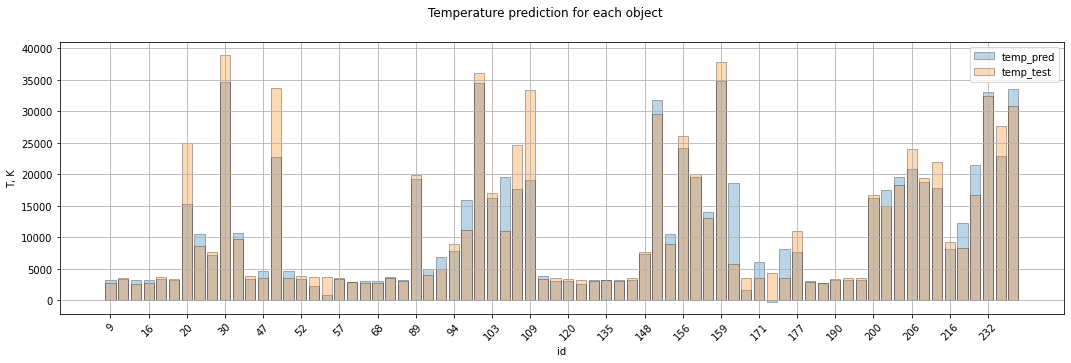

In [44]:
fig, ax = plt.subplots(figsize = (18, 5))

result = best_result_drp.sort_values(by = 'index')

ax.bar(result['index'].astype('str'),  result['temp_pred'], edgecolor='black', alpha=0.3, label = 'temp_pred')
ax.bar(result['index'].astype('str'),  result['temp'], edgecolor='black', alpha=0.3, label = 'temp_test')
ax.set_xticks(list(result['index'].astype('str')[::3]))

plt.grid(True)
plt.xticks(rotation=45)
plt.legend(loc = "upper right")
plt.suptitle("Temperature prediction for each object")
plt.xlabel('id')
plt.ylabel('T, K')
plt.show()

## **General conclusion**

In this project, a model based on a neural network was built to predict the temperature of a star

The following steps were completed:
- data analysis and preprocessing:
    - errors were detected in filling in the color attribute
    - replaced column names
- preparation of data for training:
    - breakdown into train and test parts
    - scaling of quantitative features
    - OHE-coding of categorical features
- the neural network class is defined:
    - choice of network architecture (number of layers and neurons, activation functions and loss functions)
- neural network training without selection of regularization parameters
    - the number of training epochs and the training step are selected
- next, the stage of regularization of parameters was performed, Dropout methods and optimization of the size of the batch were considered

The best result was achieved on the number of training epochs 2000 in increments of 200 and dropout: **RSME - 3660**